This code inputs non-renormalized coarse-grained data (via a Lucy function), calculates the relevant velocity field data and calculates the residual from the vorticity conservation equation. This residual represents the viscous contribution to the flow.

In [802]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import nnls

In [803]:
def gaussian_smooth(u,nx,nz,sigma):
    return gaussian_filter(u.reshape((nx,nz)),sigma=sigma).reshape(u.shape)

In [804]:
def phi(X_i,X_j,a2):

    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            #r2 = (X_i[i,0] - X_j[j,0])**2 + (X_i[i,1] - X_j[j,1])**2
            #r = np.sqrt(r2)
            #phimat[i,j] = np.sqrt(1 + a2*r2)
            #phimat[i,j] = r**3*np.log(r**r)
            #phimat[i,j] = r**3
            phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def nablaphi(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 16*(x_i - x_j)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 16*(x_i - x_j)**2 + 16*(z_i - z_j)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 16*(z_i - z_j)**2
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    return phimat 

def dphidx(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def dphidz(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 2*(z_i - z_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def d2phidx2(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            phimat[i,j] = 14*(x_i - x_j)**2 + 2*(z_i - z_j)**2 + 4*(3*(x_i - x_j)**2 + (z_i - z_j)**2)*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

def d2phidz2(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            phimat[i,j] = 2*(x_i - x_j)**2 + 14*(z_i - z_j)**2 + 4*((x_i - x_j)**2 + 3*(z_i - z_j)**2)*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

def d2phidxdz(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            4*(x_i - x_j)*(z_i - z_j)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 3)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

In [805]:
#numerical parameters
pi = 3.14159

In [806]:
#building grid:

RCG = '0_01'

#data = np.loadtxt('/home/bay22/git_repositories/RIMSAR/data/03_processed/renormalized_coarse_grain/RCG_c'+RCG+'.dat')
data = np.loadtxt('/home/bay22/git_repositories/RIMSAR/data/03_processed/coarse_grain/RCG_c'+RCG+'.dat')
#data = np.loadtxt('cavityNonNewtonian_n2_k0_01_0.csv',delimiter = ',')
plt.figure(figsize=(8,8))
u_data = data[:,3] 
v_data = -data[:,4]
rho_data = data[:,2]
Xu = data[:,0]
Zu = data[:,1]

#normalizing density:

rho_data /= np.max(rho_data)


#smoothing velocity data
#u_data = gaussian_filter(u_data.reshape((100,100)),sigma=5).flatten()
#v_data = gaussian_filter(v_data.reshape((100,100)),sigma=5).flatten()




<Figure size 576x576 with 0 Axes>

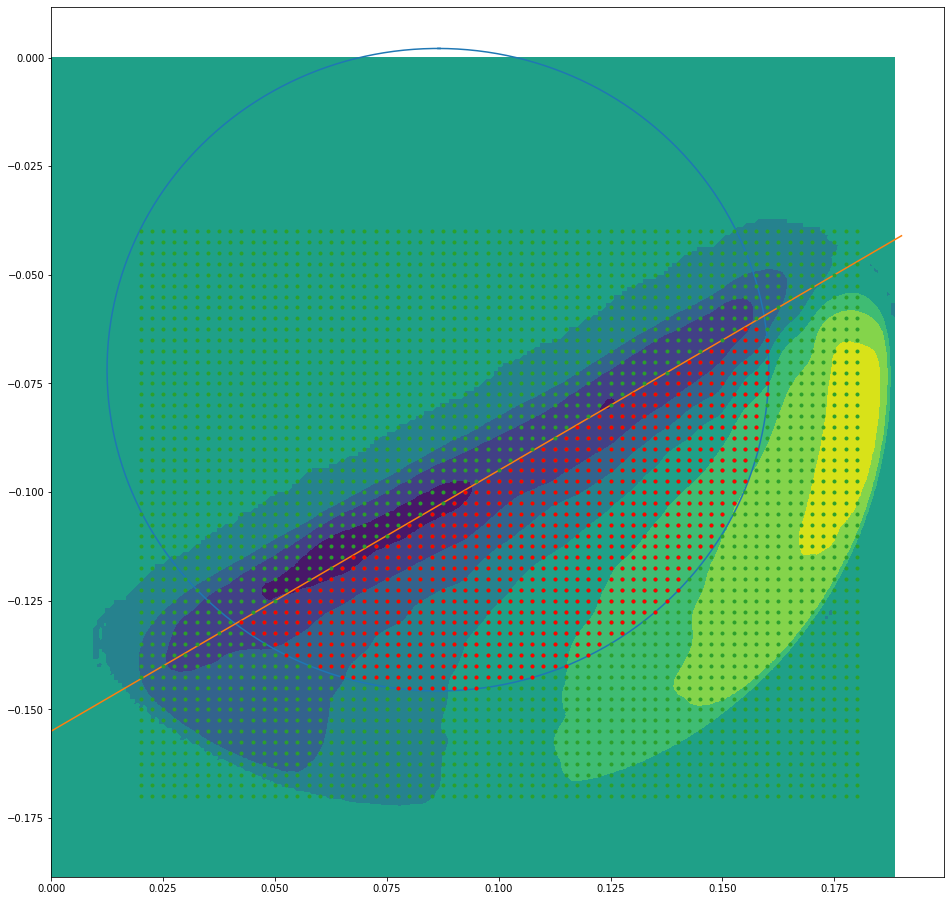

In [807]:
dx = 0.0025
xx,zz = np.meshgrid(np.arange(0.02,0.18+dx,dx),np.arange(-0.17,-0.04+dx,dx))
Xtotal = np.stack((xx.flatten(),zz.flatten()),axis=1)
nx = xx.shape[0]
nz = xx.shape[1]



#removing points outside of circle:
dt = 0.01



pixel2real = 0.0001848337
xc = 467.5*pixel2real
zc = 388.6*pixel2real
#r = 524.8*pixel2real #true radius
#r = 480*pixel2real
r = 400*pixel2real
theta = np.arange(0,2*3.14159+dt,dt)
xcircle = xc + r*np.sin(theta)
zcircle = -zc + r*np.cos(theta)
xline = np.arange(0,0.2,0.01)
m = 0.6
c = -0.155
yline = xline*m + c
X_interior = Xtotal[Xtotal[:,1]-m*Xtotal[:,0]-c<=0,:]
X_interior = X_interior[(X_interior[:,0]-xc)**2 + (X_interior[:,1]+zc)**2 - r**2 <= 0,:]

interior_index0 = np.argwhere(Xtotal[:,1]-m*Xtotal[:,0]-c<=0)
interior_index1 = np.argwhere((Xtotal[:,0]-xc)**2 + (Xtotal[:,1]+zc)**2 - r**2 <= 0) 

interior_index = np.intersect1d(interior_index0,interior_index1)
X_interior = Xtotal[interior_index,:]


plt.figure(figsize=(16,16))
#plt.tricontourf(Xu,Zu,np.sqrt(u_data**2 + v_data**2))
plt.tricontourf(Xu,Zu,v_data)
plt.plot(xcircle,zcircle)
plt.plot(xline,yline)
plt.plot(xx.flatten(),zz.flatten(),'.')
plt.plot(X_interior[:,0],X_interior[:,1],'.',color = 'r')
X = X_interior + 0


In [808]:
#finding nnearest neighbours of each point in Xj
r2 = (X[:,0:1]-X[:,0:1].transpose())**2 + (X[:,1:2]-X[:,1:2].transpose())**2

X_neighbours = np.zeros((X.shape[0],9),dtype = int)

X_neighbours = np.zeros((X.shape[0],9),dtype = int)
for i in range(0,X.shape[0]):
    X_neighbours[i,:] = (np.argpartition(r2[:,i],9)[0:9])


u_interp = LinearNDInterpolator(list(zip(Xu,Zu)), u_data)
v_interp = LinearNDInterpolator(list(zip(Xu,Zu)), v_data)
rho_interp = LinearNDInterpolator(list(zip(Xu,Zu)), rho_data)

u_test = u_interp(Xtotal[:,0:1],Xtotal[:,1:2])
v_test = v_interp(Xtotal[:,0:1],Xtotal[:,1:2])
rho_test = rho_interp(Xtotal[:,0:1],Xtotal[:,1:2])

u_test[np.isnan(u_test)] = 0
v_test[np.isnan(v_test)] = 0
rho_test[np.isnan(rho_test)] = 0

#plt.tricontourf(X_interior[:,0],X_interior[:,1],X_interior[:,0]*m+c-X_interior[:,1])

In [809]:
#calculating velocity derivatives:

recalculate_velocity = True

if recalculate_velocity:
    phi_matu = phi(Xtotal,Xtotal,0)
    dphidx_matu = dphidx(Xtotal,Xtotal,0)
    dphidz_matu = dphidz(Xtotal,Xtotal,0)
    d2phidxdz_matu = d2phidxdz(Xtotal,Xtotal,0)
    d2phidx2_matu = d2phidx2(Xtotal,Xtotal,0)
    d2phidz2_matu = d2phidz2(Xtotal,Xtotal,0)

    #in velocity space:
    phi_invu = np.linalg.inv(phi_matu)
    dphidx_matu = np.matmul(dphidx_matu,phi_invu)
    dphidz_matu = np.matmul(dphidz_matu,phi_invu)
    d2phidx2_matu = np.matmul(d2phidx2_matu,phi_invu)
    d2phidz2_matu = np.matmul(d2phidz2_matu,phi_invu)
    d2phidxdz_matu = np.matmul(d2phidxdz_matu,phi_invu)
    nabla2_matu = d2phidx2_matu + d2phidz2_matu





/tmp/ipykernel_1436/1795213519.py:15: RuntimeWarning: divide by zero encountered in log
  phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
/tmp/ipykernel_1436/1795213519.py:15: RuntimeWarning: invalid value encountered in double_scalars
  phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
/tmp/ipykernel_1436/1795213519.py:44: RuntimeWarning: divide by zero encountered in log
  phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
/tmp/ipykernel_1436/1795213519.py:44: RuntimeWarning: invalid value encountered in double_scalars
  phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
/tmp/ipykernel_1436/1795213519.py:59: RuntimeWarning: divide by zero encountered in log
  phimat[i,j] = 2*(z_i - z_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
/tmp/ipykernel_143

In [810]:
dphidx_matu.shape 

(3445, 3445)

In [811]:
#smoothing factor
sigma = 2
dsigma = 0
d2sigma = 0

u_test = gaussian_smooth(u_test,nx,nz,sigma)
v_test = gaussian_smooth(v_test,nx,nz,sigma)
rho_test = gaussian_smooth(rho_test,nx,nz,sigma)

#velocity fields:
u = np.diag(u_test[interior_index,0])
v = np.diag(v_test[interior_index,0])
dudz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,u_test),nx,nz,dsigma)[interior_index,0] )
dudztest = gaussian_smooth(np.matmul(dphidz_matu,u_test),nx,nz,dsigma)[:,0]
dudx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,u_test),nx,nz,dsigma)[interior_index,0])
d2udx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,u_test),nx,nz,d2sigma)[interior_index,0])
d2udz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,u_test),nx,nz,d2sigma)[interior_index,0])
d2udxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test),nx,nz,d2sigma)[interior_index,0])

dvdz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,v_test),nx,nz,dsigma)[interior_index,0])
dvdx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,v_test),nx,nz,dsigma)[interior_index,0])
d2vdx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,v_test),nx,nz,d2sigma)[interior_index,0])
d2vdz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,v_test),nx,nz,d2sigma)[interior_index,0])
d2vdxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,v_test),nx,nz,d2sigma)[interior_index,0])

d2puudxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test*u_test*rho_test),nx,nz,d2sigma)[:,0] )
d2puvdz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,u_test*v_test*rho_test),nx,nz,d2sigma)[:,0] )
d2puvdx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,u_test*v_test*rho_test),nx,nz,d2sigma)[:,0] )
d2pvvdxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test*v_test*rho_test),nx,nz,d2sigma)[:,0] )

d3udz3 = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidz_matu,d2phidz2_matu),u_test),nx,nz,d2sigma)[interior_index,0])
d3vdx3 = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidx_matu,d2phidx2_matu),v_test),nx,nz,d2sigma)[interior_index,0])
d3udx2dz = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidz_matu,d2phidx2_matu),u_test),nx,nz,d2sigma)[interior_index,0])
d3vdxdz2 = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidx_matu,d2phidz2_matu),v_test),nx,nz,d2sigma)[interior_index,0])





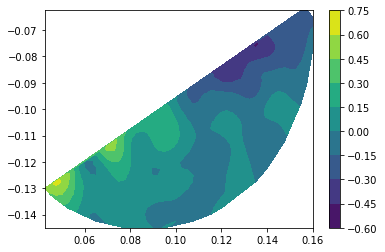

In [812]:
#checking continuity:

dpudx = np.matmul(dphidx_matu,rho_test*u_test)
dpvdz = np.matmul(dphidz_matu,rho_test*v_test)
plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],(dpudx+dpvdz)[interior_index,0])
plt.colorbar()
#plt.plot(np.abs((dpudx+dpvdz)[:,0]),'.')
#plt.yscale('log')

The navier-stokes vorticity equation is given by
$ \frac{\partial^2 \rho u^2}{\partial x \partial z} + \frac{\partial^2 \rho u v}{\partial z^2} - \frac{\partial \rho u v}{\partial x^2} - \frac{\partial^2 \rho v^2}{\partial x \partial z}$

In [813]:
vorticity_residual = np.diag(d2puudxdz) + np.diag(d2puvdz2) - np.diag(d2puvdx2) - np.diag(d2pvvdxdz)

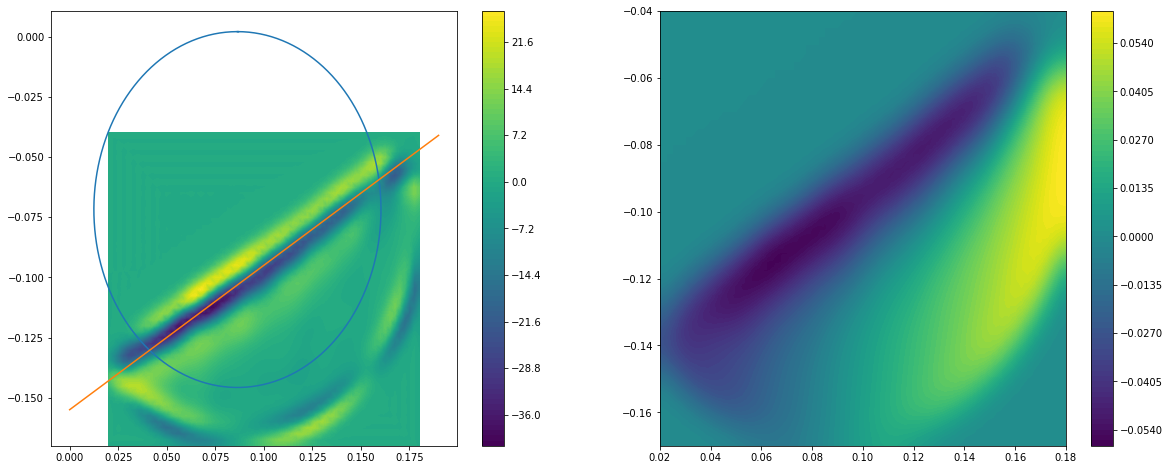

In [814]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
#plt.tricontourf(Xtotal[:,0],Xtotal[:,1],v_test[:,0],levels=100)
plt.tricontourf(Xtotal[:,0],Xtotal[:,1],vorticity_residual,levels=100)
#plt.tricontour(Xtotal[:,0],Xtotal[:,1],rho_test.flatten(),levels=5)
plt.plot(xcircle,zcircle)
plt.plot(xline,yline)
plt.colorbar()
plt.subplot(1,2,2)
plt.tricontourf(Xtotal[:,0],Xtotal[:,1],v_test[:,0],levels=100)
#plt.tricontourf(Xtotal[:,0],Xtotal[:,1],rho_test.flatten(),levels=100)
plt.colorbar()

In [815]:
if True:

    phi_mat = phi(X_interior,X_interior,0)
    dphidx_mat = dphidx(X_interior,X_interior,0)
    dphidz_mat = dphidz(X_interior,X_interior,0)
    d2phidxdz_mat = d2phidxdz(X_interior,X_interior,0)
    d2phidx2_mat = d2phidx2(X_interior,X_interior,0)
    d2phidz2_mat = d2phidz2(X_interior,X_interior,0)

    #in velocity space:
    phi_inv = np.linalg.inv(phi_mat)
    dphidx_mat = np.matmul(dphidx_mat,phi_inv)
    dphidz_mat = np.matmul(dphidz_mat,phi_inv)
    d2phidx2_mat = np.matmul(d2phidx2_mat,phi_inv)
    d2phidz2_mat = np.matmul(d2phidz2_mat,phi_inv)
    d2phidxdz_mat = np.matmul(d2phidxdz_mat,phi_inv)
    nabla2_mat = d2phidx2_mat + d2phidz2_mat

/tmp/ipykernel_1436/1795213519.py:15: RuntimeWarning: divide by zero encountered in log
  phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
/tmp/ipykernel_1436/1795213519.py:15: RuntimeWarning: invalid value encountered in double_scalars
  phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
/tmp/ipykernel_1436/1795213519.py:44: RuntimeWarning: divide by zero encountered in log
  phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
/tmp/ipykernel_1436/1795213519.py:44: RuntimeWarning: invalid value encountered in double_scalars
  phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
/tmp/ipykernel_1436/1795213519.py:59: RuntimeWarning: divide by zero encountered in log
  phimat[i,j] = 2*(z_i - z_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
/tmp/ipykernel_143

In [816]:
N = phi_mat.shape[0]
phi_mat = np.eye(phi_mat.shape[0])
gov_mat = np.zeros((N,N))

#horizontal momentum:

#viscosity terms
gov_mat = np.matmul(d3udz3,phi_mat) - np.matmul(d3vdx3,phi_mat) #tick
gov_mat += np.matmul(d3udx2dz,phi_mat) - np.matmul(d3vdxdz2,phi_mat) #tick
gov_mat += -2*np.matmul(d2vdx2,dphidx_mat) -2*np.matmul(d2vdz2,dphidx_mat) #tick
gov_mat += -np.matmul(dudz,d2phidx2_mat) -np.matmul(dvdx,d2phidx2_mat) #tick
gov_mat +=  + 2*np.matmul(d2udx2,dphidz_mat) + 2*np.matmul(d2udz2,dphidz_mat) #tick
gov_mat += np.matmul(dudz,d2phidz2_mat) + np.matmul(dvdx,d2phidz2_mat) #tick
gov_mat += 2*np.matmul(dudx,d2phidxdz_mat) - 2*np.matmul(dvdz,d2phidxdz_mat) #tick


In [817]:
#boundary conditions

bc_vector = np.zeros((N,1))
bc_vector[0:N,0] = vorticity_residual[interior_index]


In [818]:
#building solution matrix:
#viscosity_smoothness_parameter = 100000
viscosity_smoothness_parameter = 100000
LS_mat = np.zeros((3*N,N))
LS_vect = np.zeros((3*N,1))

LS_mat[0:N,0:N] = gov_mat
LS_mat[N:2*N,0:N] = viscosity_smoothness_parameter*dphidx_mat*dx
LS_mat[2*N:3*N,0:N] = viscosity_smoothness_parameter*dphidz_mat*dx

LS_vect[0:N,:] = bc_vector
LS_solution = np.linalg.lstsq(LS_mat,LS_vect)

#LS_solution = nnls(LS_mat,LS_vect[:,0])

/tmp/ipykernel_1436/1403786914.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LS_solution = np.linalg.lstsq(LS_mat,LS_vect)


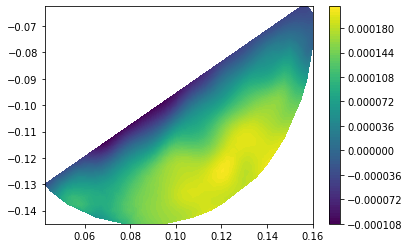

In [819]:
plt.tricontourf(X_interior[:,0],X_interior[:,1],LS_solution[0][0:N,0],levels=100)
plt.colorbar()

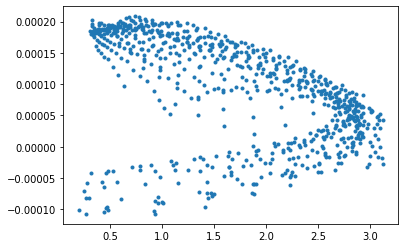

In [820]:
gamma = 0.5**0.5*(np.diag(dudx)**2 + 0.5*(np.diag(dvdx)+np.diag(dudz))**2 + np.diag(dvdz)**2 )**0.5
plt.plot(gamma,LS_solution[0][0:N,:],'.')

(0.001, 0.05)

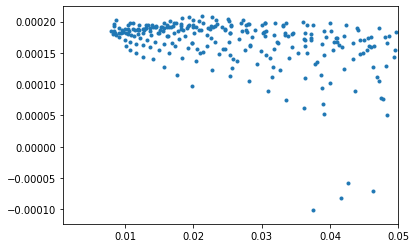

In [821]:
hs_pressure = (X_interior[:,0]*m+c-X_interior[:,1])*1700*6.5
I = np.sqrt(2700)*0.012*gamma/np.sqrt(hs_pressure)
plt.plot(I,LS_solution[0][0:N,:],'.')
plt.xlim([0.001,0.05])

(0.0, 0.0002)

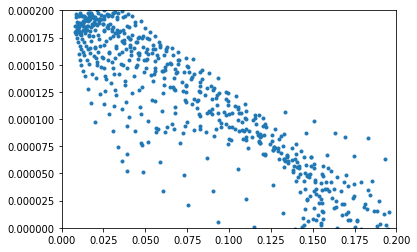

In [822]:
plt.plot(I,LS_solution[0][0:N,:],'.')
plt.xlim([0,0.2])
plt.ylim([0,0.0002])

In [823]:
print(LS_solution[0].shape)

(750, 1)


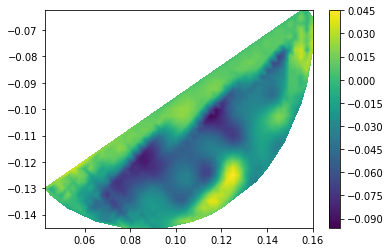

In [824]:
err = np.matmul(gov_mat,LS_solution[0])-bc_vector
err_normalizing_factor = np.sqrt(np.mean(bc_vector**2))
err /= np.max(np.abs(bc_vector))
plt.tricontourf(X_interior[:,0],X_interior[:,1],err[:,0],levels=100)
#plt.tricontourf(X_interior[:,0],X_interior[:,1],bc_vector[:,0],levels=100)
plt.colorbar()
